In [24]:
import sys
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Local
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))

from utils.utils import count_parameters, create_sequence
from utils.train import train_and_validate
from utils.watertopo import WaterTopo

In [4]:
#initialize GPU -  In case of windows use cuda instead of nps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA enabled?",torch.cuda.is_available())
print("Number of GPUs",torch.cuda.device_count())

Is CUDA enabled? False
Number of GPUs 0


In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [7]:
model = UNet(2, 1, False)

print(f"U-Net --> num. trainable parameters:{count_parameters(model):8d}")

ConvLSTM --> num. trainable parameters:31037057


In [37]:
sim_amount = 1
use_augmented_data = False
T = 1
H = 1
training_size = 0.8
batch_size = 1
num_epochs = 200
lr = 0.0005
criterion = nn.MSELoss()
optimizer = optim.AdamW
model_name = "unet_test"

In [38]:
sims = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val", sim_amount=sim_amount, number_grids=64, use_augmented_data=use_augmented_data)

X, Y = create_sequence(sims, T, H)
X, Y = X.squeeze(1), Y.squeeze(1)

X, Y = X[:8],Y[:8]

# We keep track of indexes of train and validation.
X_tra, X_tst, Y_tra, Y_tst, ix_tra, ix_tst = train_test_split(
    X, Y, np.arange(X.shape[0]), test_size=1-training_size, shuffle=True, random_state=42)

# Split the existing test dataset into validation and test sets (50/50 split)
X_val, X_tst, Y_val, Y_tst, ix_val, ix_tst = train_test_split(
    X_tst, Y_tst, ix_tst, test_size=0.5, shuffle=True, random_state=42)

#create datasets and data loaders
train_dataset = TensorDataset(torch.tensor(X_tra, dtype=torch.float32), torch.tensor(Y_tra, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# defining the optimizer
optimizer = optimizer(model.parameters(), lr=lr)

# defining the save path
save_path = "../results/trained_models/" + model_name

# training
train_losses, val_losses, best_val_loss, time = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path)

# Load the best model
model.load_state_dict(torch.load(save_path))

Epoch 20/200 Train Loss: 0.0001, Validation Loss: 0.0001 Best Validation Loss: 0.0000
Epoch 40/200 Train Loss: 0.0000, Validation Loss: 0.0000 Best Validation Loss: 0.0000
Epoch 60/200 Train Loss: 0.0000, Validation Loss: 0.0001 Best Validation Loss: 0.0000
Epoch 80/200 Train Loss: 0.0000, Validation Loss: 0.0000 Best Validation Loss: 0.0000
Epoch 100/200 Train Loss: 0.0000, Validation Loss: 0.0001 Best Validation Loss: 0.0000
Epoch 120/200 Train Loss: 0.0000, Validation Loss: 0.0000 Best Validation Loss: 0.0000
Epoch 140/200 Train Loss: 0.0000, Validation Loss: 0.0000 Best Validation Loss: 0.0000
Epoch 160/200 Train Loss: 0.0000, Validation Loss: 0.0000 Best Validation Loss: 0.0000
Epoch 180/200 Train Loss: 0.0000, Validation Loss: 0.0000 Best Validation Loss: 0.0000
Epoch 200/200 Train Loss: 0.0000, Validation Loss: 0.0000 Best Validation Loss: 0.0000
Training complete.


<All keys matched successfully>

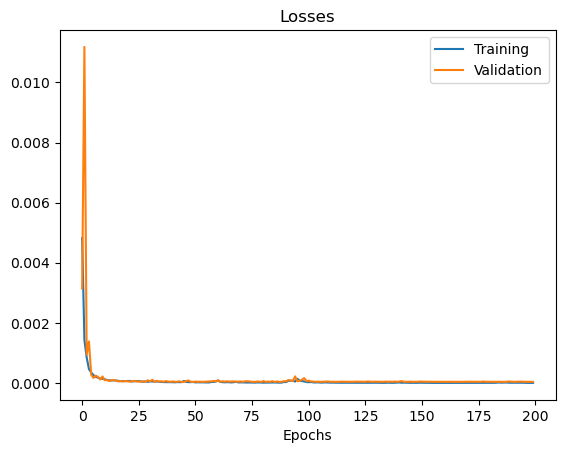

In [39]:
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
# plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

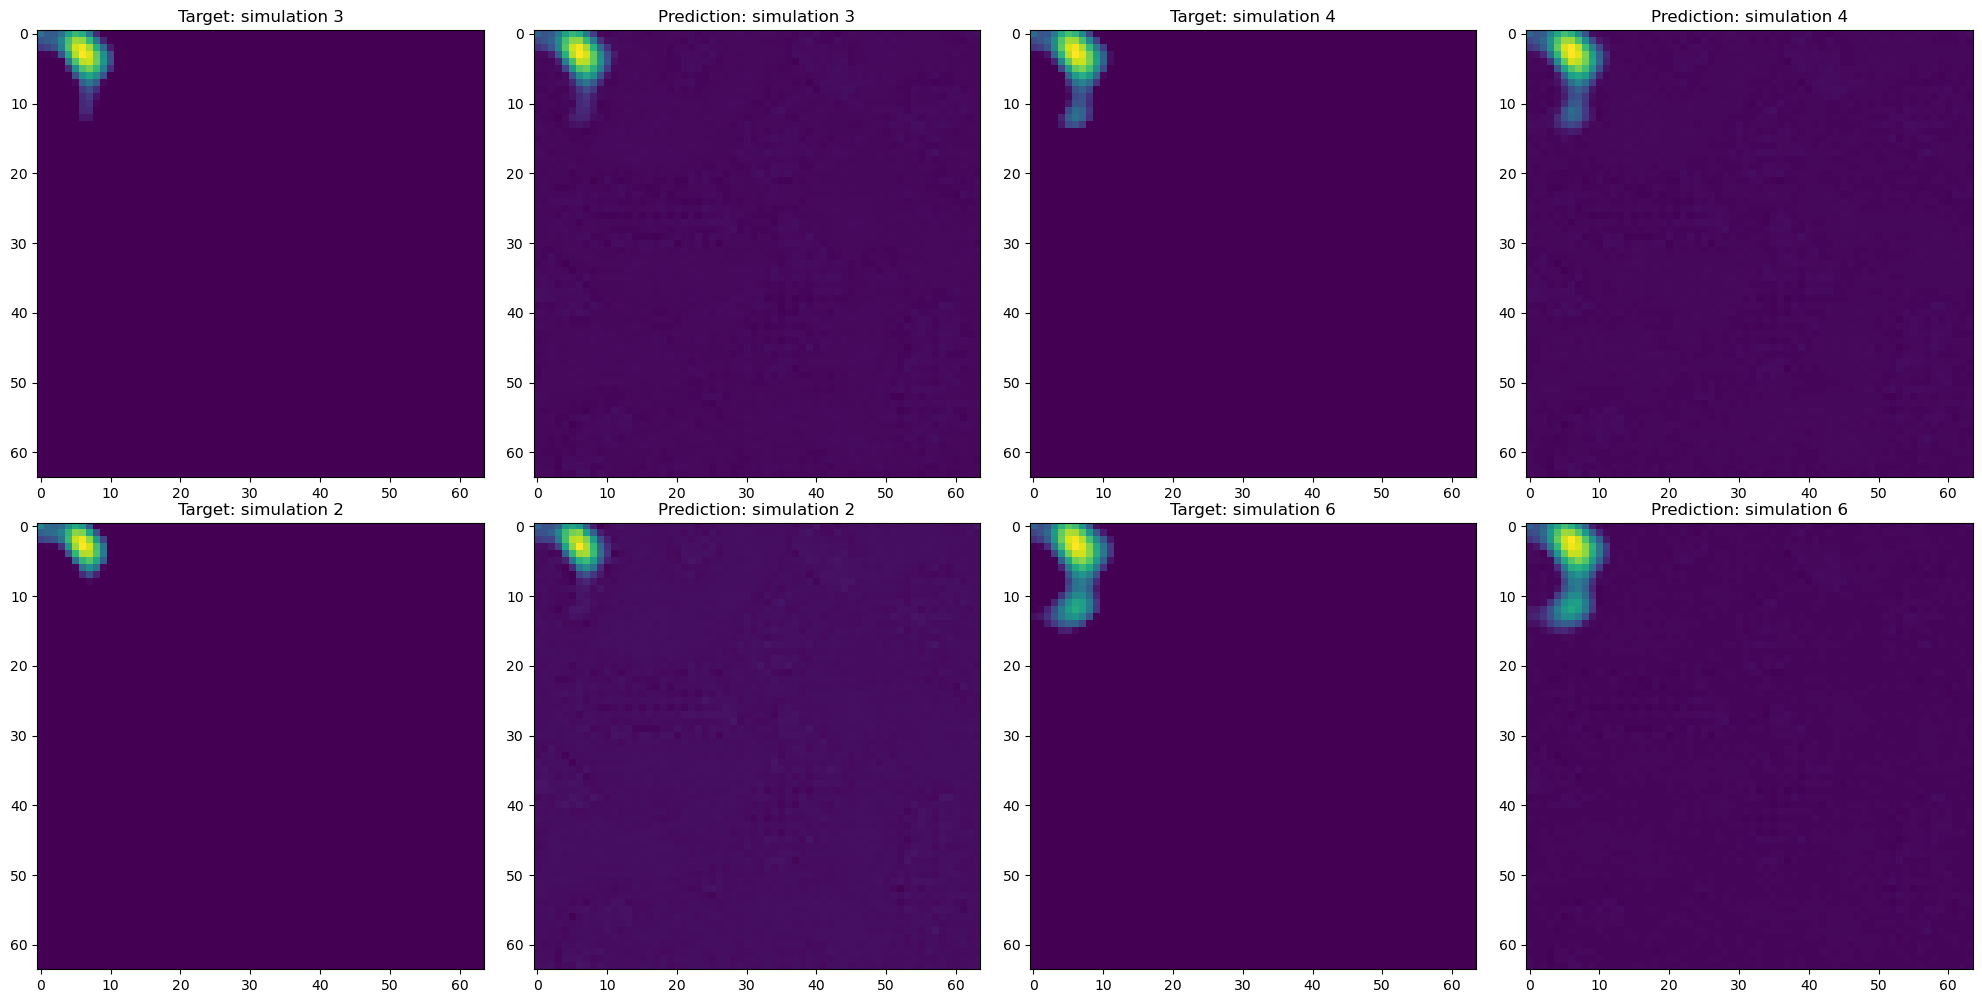

In [41]:
model.eval()

grid_size = 64
channels = 2

f,axs = plt.subplots(2, 4, figsize=(20,10))
axs = axs.reshape(-1)

for i in range(0, len(axs), 2):
  with torch.no_grad():
      # Randomly select a simulation
      idx = random.randint(0, X.shape[0]-1)
      inputs = X[idx]
      targets = Y[idx]

      # Predict
      inputs = torch.tensor(inputs, dtype=torch.float32)
      inputs = inputs.unsqueeze(0)
      prediction = model(inputs)

      # Plotting inputs (time series)
      axs[i].imshow(targets.reshape([64, 64, 1]))
      axs[i+1].imshow(prediction.reshape([64, 64, 1]))

      axs[i].set_title(f"Target: simulation {idx}")
      axs[i+1].set_title(f"Prediction: simulation {idx}")

f.tight_layout()

(8, 64, 64) torch.Size([8, 64, 64])


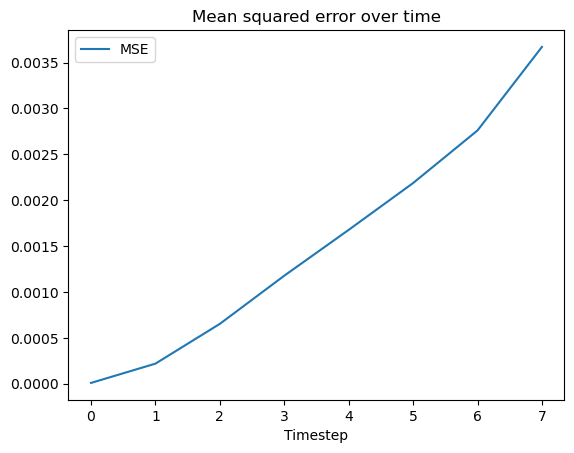

In [96]:
from utils.utils import recursive_pred
from utils.utils import mse_per_timestep

outputs = recursive_pred(model, X[0],  X.shape[0])
mse = mse_per_timestep(Y, outputs)

plt.plot(mse, label='MSE')
plt.title('Mean squared error over time')
plt.xlabel('Timestep')
plt.legend()
plt.show()